# Classification

In this lab, we will be building and evaluating different classifiers for recognising handwritten digits of MNIST dataset. We will be doing the following:

1. Binary Classification of MNIST Dataset

In the first set of tasks, you will evaluate a number of popular classifiers for the task of recognizing handwritten digits from MNIST dataset. Specifically, we will focus on distinguishing between 7 and 9 which are known to be a hard pair. 

2. Exploration of Different Evaluation Metrics. 

In the second set of tasks, you will learn how (and when) to use evaluation metrics for classifiers.

3. Parameter Tuning through Grid Search/Cross Validation and Parallelization.

You will learn how to tune your classifier and find optimal parameters using grid search. This is a very computationally intensive task - so you will also explore how to leverage parallelization capabilities of IPython kernel to get results sooner.

# Assignment in Data Mining - University of Warwick

In [2]:
%matplotlib inline 

#Array processing
import numpy as np

#Data analysis, wrangling and common exploratory operations
import pandas as pd
from pandas import Series, DataFrame

#For visualization. Matplotlib for basic viz and seaborn for more stylish figures + statistical figures not in MPL.
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import Image

from sklearn.datasets import fetch_mldata                                                                       
from sklearn.utils import shuffle                                                                                   
from sklearn import metrics                                                                                                  
from sklearn import tree                                                                                                     
from sklearn.tree import DecisionTreeClassifier                                                       
from sklearn.naive_bayes import MultinomialNB  
from sklearn.linear_model import LogisticRegression                                            
from sklearn.ensemble import RandomForestClassifier                                                                                                          
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV                                                
from sklearn.preprocessing import StandardScaler

import pydot, io
import time

#######################End imports###################################


## Part 1: Binary Classification of MNIST Dataset

In the first set of tasks, you will evaluate a number of popular classifiers for the task of recognizing handwritten digits from MNIST dataset. Specifically, we will focus on distinguishing between 7 and 9 which are known to be a hard pair.

In [4]:
try:
    mnist = fetch_mldata("MNIST original")                                                                                   
 
except Exception as ex: 
    from tensorflow.g3doc.tutorials.mnist import input_data
    #import tensorflow.examples.tutorials.mnist.input_data as import input_data
    m=input_data.read_data_sets("MNIST")
    data = np.concatenate((m.train.images, m.test.images))
    target = np.concatenate((m.train.labels, m.test.labels))
    class dataFrame:
        def __init__(self, data, target):
            self.data = data
            self.target = target
    mnist = dataFrame(data, target)

#The data is organized as follows:
#  Each row corresponds to an image
#  Each image has 28*28 pixels which is then linearized to a vector of size 784 (ie. 28*28)
# mnist.data gives the image information while mnist.target gives the number in the image
#print("#Images = %d and #Pixel per image = %s" % (mnist.data.shape[0], mnist.data.shape[1]))
print(mnist.data.shape)                                                                           
                                                                                                                             
#First 60K images are for training and last 10K are for testing
all_train_data = mnist.data[:60000]                                                                                          
all_test_data = mnist.data[60000:]                                                                                           
all_train_labels = mnist.target[:60000]                                                                                      
all_test_labels = mnist.target[60000:]                                                                                       
                                                              
#TASK IS TO DISTINGUISH 7 AND 9 in Handwritten MNIST                                                                                                                       
#  numbers: 7 and 9 which are known to be hard to distinguish
#Get all the seven images
sevens_data = mnist.data[mnist.target==7]      
#Get all the none images
nines_data = mnist.data[mnist.target==9]       
#Merge them to create a new dataset
binary_class_data = np.vstack([sevens_data, nines_data])    
binary_class_labels = np.hstack([np.repeat(7, sevens_data.shape[0]), np.repeat(9, nines_data.shape[0])])    
 
#In order to make the experiments repeatable, we will seed the random number generator to a known value
# That way the results of the experiments will always be same
np.random.seed(1234)                        
#randomly shuffle the data
binary_class_data, binary_class_labels = shuffle(binary_class_data, binary_class_labels)  
print("Shape of data and labels are :" , binary_class_data.shape, binary_class_labels.shape)  

#There are approximately 14K images of 7 and 9. 
#Let us take the first 5000 as training and remaining as test data                                          
orig_binary_class_training_data = binary_class_data[:5000]                                                  
binary_class_training_labels = binary_class_labels[:5000]                                                   
orig_binary_class_testing_data = binary_class_data[5000:]                                                   
binary_class_testing_labels = binary_class_labels[5000:] 

#The images are in grey scale where each number is between 0 to 255
# Now let us normalize them so that the values are between 0 and 1. 
# This will be the only modification we will make to the image
binary_class_training_data = orig_binary_class_training_data / 255.0                                        
binary_class_testing_data = orig_binary_class_testing_data / 255.0                                          
scaled_training_data = all_train_data / 255.0                                                                                
scaled_testing_data = all_test_data / 255.0  

print(binary_class_training_data[0,:])                                                                 
     
###########Make sure that you remember the variable names and their meaning
#binary_class_training_data, binary_class_training_labels: Normalized images of 7 and 9 and the correct labels for training
#binary_class_testing_data, binary_class_testing_labels : Normalized images of 7 and 9 and correct labels for testing
#orig_binary_class_training_data, orig_binary_class_testing_data: Unnormalized images of 7 and 9
#all_train_data, all_test_data: un normalized images of all digits 
#all_train_labels, all_test_labels: labels for all digits
#scaled_training_data, scaled_testing_data: Normalized version of all_train_data, all_test_data for all digits


/Users/Geethika/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Geethika/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


(70000, 784)
Shape of data and labels are : (14251, 784) (14251,)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

## Binary Classification in scikit-learn

All classifiers in scikit-learn follow a common pattern that makes life much easier. 
Follow these steps for all the tasks below.

1. Instantiate the classifier with appropriate parameters
2. Train/fit the classifier with training data and correct labels
3. Test the classifier with unseen data
4. Evaluate the performance of classifier

 Decision Trees 

In [5]:
###Do not make any change below
def plot_dtree(model,fileName):                                                                                              
    #You would have to install a Python package pydot                                                                        
    #You would also have to install graphviz for your system - see http://www.graphviz.org/Download..php                     
    #If you get any pydot error, see url
    # http://stackoverflow.com/questions/15951748/pydot-and-graphviz-error-couldnt-import-dot-parser-loading-of-dot-files-will
    dot_tree_data = io.StringIO()                                                                                      
    tree.export_graphviz(model, out_file = dot_tree_data)                                                                   
    (dtree_graph,) = pydot.graph_from_dot_data(dot_tree_data.getvalue())                                                        
    dtree_graph.write_png(fileName)                   

In [6]:

from sklearn.tree import plot_tree
ds = DecisionTreeClassifier(criterion='entropy',random_state=1234)
ds.fit(binary_class_training_data,binary_class_training_labels)
pred = ds.predict(binary_class_testing_data)
print(metrics.accuracy_score(pred,binary_class_testing_labels ))
print(plot_dtree(ds,"dtree.png"))

0.9694087125716139
None


Naive Bayes 

In [7]:

mnb = MultinomialNB()
mnb.fit(binary_class_training_data,binary_class_training_labels)
pred_mnb = mnb.predict(binary_class_testing_data)
print(metrics.accuracy_score(pred_mnb,binary_class_testing_labels ))

0.9159009836774403


Logistic Regression


In [8]:
# Create a model with default parameters. Remember to set random state to 1234
lg = LogisticRegression(random_state=1234)
lg.fit(binary_class_training_data,binary_class_training_labels)
pred_lg = lg.predict(binary_class_testing_data)
print(metrics.accuracy_score(pred_lg,binary_class_testing_labels ))

/Users/Geethika/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9573019133066696


 Random Forests 

In [9]:
# Create a random forest classifier with Default parameters
rfc = RandomForestClassifier()
rfc.fit(binary_class_training_data,binary_class_training_labels)
pred_rfc = rfc.predict(binary_class_testing_data)
print(metrics.accuracy_score(pred_rfc,binary_class_testing_labels ))

/Users/Geethika/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9754621122040861


## Part 2: Exploration of Different Evaluation Metrics for Binary Classification


### Exercise 5: Print the classification results 

For each of the models above:

- Task 5a: Print the classification report and confusion matrix (5 marks)
- Task 5b: Print the ROC curve (5 marks)
- Task 5c: Print the AUC curve (5 marks)
- Task 5d: Print the precision/recall curve (5 marks)

In [10]:
# task t5a (5 marks)
# Print the classification report and confusion matrix for each of the models above
# Write code here
print("classification report of desicion tree")
print(metrics.classification_report(pred,binary_class_testing_labels))
print("confusion matrix of desicion tree")
print(metrics.confusion_matrix(pred,binary_class_testing_labels ))
print("classification report of Multinomail naive bayes")
print(metrics.classification_report(pred_mnb,binary_class_testing_labels))
print("confusion matrix of Multinomail naive bayes")
print(metrics.confusion_matrix(pred_mnb,binary_class_testing_labels ))
print("classification report of logistic regression")
print(metrics.classification_report(pred_lg,binary_class_testing_labels))
print("confusion matrix of logistic regression")
print(metrics.confusion_matrix(pred_lg,binary_class_testing_labels ))
print("classification report of random forest classifier")
print(metrics.classification_report(pred_rfc,binary_class_testing_labels))
print("confusion matrix of random forest classifier")
print(metrics.confusion_matrix(pred_rfc,binary_class_testing_labels))


classification report of desicion tree
              precision    recall  f1-score   support

           7       0.97      0.97      0.97      4705
           9       0.97      0.96      0.97      4546

    accuracy                           0.97      9251
   macro avg       0.97      0.97      0.97      9251
weighted avg       0.97      0.97      0.97      9251

confusion matrix of desicion tree
[[4584  121]
 [ 162 4384]]
classification report of Multinomail naive bayes
              precision    recall  f1-score   support

           7       0.88      0.95      0.91      4380
           9       0.95      0.88      0.92      4871

    accuracy                           0.92      9251
   macro avg       0.92      0.92      0.92      9251
weighted avg       0.92      0.92      0.92      9251

confusion matrix of Multinomail naive bayes
[[4174  206]
 [ 572 4299]]
classification report of logistic regression
              precision    recall  f1-score   support

           7       0.96   

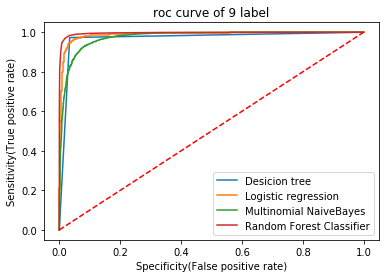

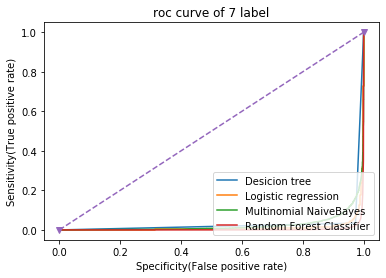

In [88]:

# Each of the model above has some probabilistic interpretation
# So sklearn allows you to get the probability values as part of classification


y_dsscore = ds.predict_proba(binary_class_testing_data)[:,1]
binary_class_testing = np.where(binary_class_testing_labels == 9, True, False)
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(binary_class_testing,y_dsscore)
false_positive_ratelg, true_positive_ratelg, thresholdslg = metrics.roc_curve(binary_class_testing,lg.predict_proba(binary_class_testing_data)[:,1])
false_positive_ratemnb, true_positive_ratemnb, thresholdsmnb = metrics.roc_curve(binary_class_testing,mnb.predict_proba(binary_class_testing_data)[:,1])
false_positive_raterfc, true_positive_raterfc, thresholdsrfc = metrics.roc_curve(binary_class_testing,rfc.predict_proba(binary_class_testing_data)[:,1])
plt.figure()
plt.plot(false_positive_rate,true_positive_rate,label= "Desicion tree")
plt.plot(false_positive_ratelg,true_positive_ratelg,label= "Logistic regression")#(area = %0.2f)"% roc_auclg
plt.plot(false_positive_ratemnb,true_positive_ratemnb,label= "Multinomial NaiveBayes")
plt.plot(false_positive_raterfc,true_positive_raterfc,label= "Random Forest Classifier")
plt.plot([0,1],[0,1],'r--')
plt.title("roc curve of 9 label")
plt.xlabel("Specificity(False positive rate)")
plt.ylabel("Sensitivity(True positive rate)")
plt.legend(loc = "lower right")
plt.show()
binary_class_testing_seven = np.where(binary_class_testing_labels == 7, True, False)
false_positive_rate_seven, true_positive_rate_seven, thresholds_seven = metrics.roc_curve(binary_class_testing_seven,y_dsscore)
false_positive_ratelg_seven, true_positive_ratelg_seven, thresholdslg_seven= metrics.roc_curve(binary_class_testing_seven,lg.predict_proba(binary_class_testing_data)[:,1])
false_positive_ratemnb_seven, true_positive_ratemnb_seven, thresholdsmnb_seven = metrics.roc_curve(binary_class_testing_seven,mnb.predict_proba(binary_class_testing_data)[:,1])
false_positive_raterfc_seven, true_positive_raterfc_seven, thresholdsrfc_seven = metrics.roc_curve(binary_class_testing_seven,rfc.predict_proba(binary_class_testing_data)[:,1])
plt.figure()
plt.plot(false_positive_rate_seven,true_positive_rate_seven,label= "Desicion tree")
plt.plot(false_positive_ratelg_seven,true_positive_ratelg_seven,label= "Logistic regression")#(area = %0.2f)"% roc_auclg
plt.plot(false_positive_ratemnb_seven,true_positive_ratemnb_seven,label= "Multinomial NaiveBayes")
plt.plot(false_positive_raterfc_seven,true_positive_raterfc_seven,label= "Random Forest Classifier")
plt.plot([0,1],[0,1],'v--')
plt.title("roc curve of 7 label")
plt.xlabel("Specificity(False positive rate)")
plt.ylabel("Sensitivity(True positive rate)")
plt.legend(loc = "lower right")
plt.show()

From the above we can see that all  model predicts the majority class of 9 and low class is 7 ,

In [91]:
# Print the AUC value for each of the models above

roc_auc = metrics.roc_auc_score(binary_class_testing,pred)
roc_auclg = metrics.roc_auc_score(binary_class_testing,pred_lg)
roc_aucmnb = metrics.roc_auc_score(binary_class_testing,pred_mnb)
roc_aucrfc = metrics.roc_auc_score(binary_class_testing,pred_rfc)
print("roc-auc-score of desicion tree of label 9:",roc_auc)
print("roc-auc-score of logistic regression label 9:",roc_auclg)
print("roc-auc-score of multinomial naive bayes label 9:",roc_aucmnb)
print("roc-auc-score of random forest classifier label 9:",roc_aucrfc)
# roc_auc_seven = metrics.roc_auc_score(binary_class_testing_seven,pred)
# roc_auclg_seven = metrics.roc_auc_score(binary_class_testing_seven,pred_lg)
# roc_aucmnb_seven = metrics.roc_auc_score(binary_class_testing_seven,pred_mnb)
# roc_aucrfc_seven = metrics.roc_auc_score(binary_class_testing_seven,pred_rfc)
# print("roc-auc-score of desicion tree of label 7",roc_auc_seven)
# print("roc-auc-score of logistic regression label 7",roc_auclg_seven)
# print("roc-auc-score of multinomial naive bayes label 7",roc_aucmnb_seven)
# print("roc-auc-score of random forest classifier label 7",roc_aucrfc_seven)

roc-auc-score of desicion tree of label 9: 0.9695034734548352
roc-auc-score of logistic regression label 9: 0.9572306464746526
roc-auc-score of multinomial naive bayes label 9: 0.9168752423326987
roc-auc-score of random forest classifier label 9: 0.9752960960640726


<!-- # Precision = True Positives / (True Positives + False Positives)

# Recall = True Positives / (True Positives + False Negatives)

# Sensitivity = True Positives / (True Positives + False Negatives)

# Recall == sensitivity

# Specificity = 1- sensitivity == False Positivies/(False positives/True Negative) -->

f1score and AUC of Desicion Tree
0.0 0.9752924489224357
f1score and AUC  of  Logistic Regression
0.0 0.9864803412011406
f1score and AUC  of  Multinomial Naive Bayes
0.0 0.9713490737249236
f1score and AUC  of  Random Forest Classifier
0.0 0.9965232904053078


/Users/Geethika/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Geethika/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


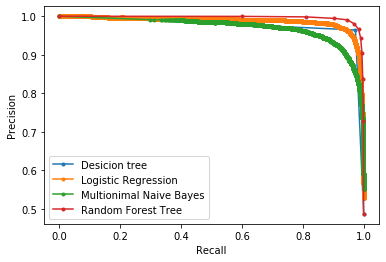

In [92]:

# Print the precision recall curve for each of the models above
 

precision, recall, thresholds = metrics.precision_recall_curve(binary_class_testing,y_dsscore)
precision_lg, recall_lg, thresholds_lg = metrics.precision_recall_curve(binary_class_testing,lg.predict_proba(binary_class_testing_data)[:,1])
precision_mnb, recall_mnb, thresholds_mnb = metrics.precision_recall_curve(binary_class_testing,mnb.predict_proba(binary_class_testing_data)[:,1])
precision_rfc, recall_rfc, thresholds_rfc = metrics.precision_recall_curve(binary_class_testing,rfc.predict_proba(binary_class_testing_data)[:,1])
f1_ds,auc_ds = metrics.f1_score(binary_class_testing,pred,average='weighted'), metrics.auc(recall, precision)
f1_lg,auc_lg = metrics.f1_score(binary_class_testing,pred_lg,average='weighted'), metrics.auc(recall_lg, precision_lg)
f1_mnb,auc_mnb = metrics.f1_score(binary_class_testing,pred_mnb,average='weighted'), metrics.auc(recall_mnb, precision_mnb)
f1_rfc,auc_rfc = metrics.f1_score(binary_class_testing,pred_rfc,average='weighted'), metrics.auc(recall_rfc, precision_rfc)
print("f1score and AUC of Desicion Tree")
print(f1_ds,auc_ds)
print("f1score and AUC  of  Logistic Regression")
print(f1_lg,auc_lg)
print("f1score and AUC  of  Multinomial Naive Bayes")
print(f1_mnb,auc_mnb)
print("f1score and AUC  of  Random Forest Classifier")
print(f1_rfc,auc_rfc)
plt.plot(recall,precision, marker='.',label='Desicion tree')
plt.plot(recall_lg,precision_lg, marker='.',label='Logistic Regression')
plt.plot(recall_mnb,precision_mnb, marker='.',label='Multionimal Naive Bayes')
plt.plot(recall_rfc,precision_rfc, marker='.',label='Random Forest Tree')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "lower left")
plt.show()

In [ ]:
# We can see that f1 score of the all models is 0.0 , the model has penalized for predicting the majority class in all cases. 
# f1 score indicated that the all the model that showed high accuracy and auc value to the ROC Curve is in fact barely predicting properly 
# when considered using using precision and recall that focus onpredicting label 9.

## Part 3: Parameter Tuning through Grid Search/Cross Validation and Parallelization

So far in this assignment, you manually tweaked the model till it became better.
For complex models, this is often cumbersome. A common trick people use is called Grid Search where you exhaustively test various parameter combinations
and pick the best set of parameter values. This is a VERY computationally intensive process and hence it will require some parallelization.

In this part, you will learn how to tune Randm Forest for MNIST dataset
and then parallelize it so as to get results faster.
You might want to take a look at the url
http://scikit-learn.org/stable/modules/grid_search.html
for additional details.

One thing you might want to note is that the GridSearchCV uses cross validation for comparing models.

So you have to send the ENTIRE MNIST dataset - i.e. mnist.data and mnist.target. 

The following cell creates two variables all_scaled_data and all_scaled_target that you can pass to GridSearchCV.

In order to get the results in reasonable time, set the **cv** parameter of GridSearchCV to 3.
Also remember to set the **verbose** parameter to 2 to get some details about what happens internally.

In [96]:

all_scaled_data = binary_class_data / 255.0
all_scaled_target = binary_class_labels

### Exercise 6: Tuning parameters for Random Forest using grid search

In [98]:

# Tuning Random Forest for MNIST
tuned_parameters =[{'max_features': ['sqrt', 'log2'], 'n_estimators': [1000, 1500]}] 
# Write code here
gs_clf = GridSearchCV(estimator = rfc, param_grid = tuned_parameters,cv = 3, verbose = 2)
gs_clf = gs_clf.fit(all_scaled_data,all_scaled_target)
# print the details of the best model and its accuracy
# Write code here
print(gs_clf.best_score_)
print(gs_clf.best_params_)
print('Improvement of {:0.3f}%.'.format( 100 * (gs_clf.best_score_ - (metrics.accuracy_score(pred_rfc,binary_class_testing_labels )))/ metrics.accuracy_score(pred_rfc,binary_class_testing_labels)))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] max_features=sqrt, n_estimators=1000 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. max_features=sqrt, n_estimators=1000, total=  39.8s
[CV] max_features=sqrt, n_estimators=1000 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.8s remaining:    0.0s


[CV] ............. max_features=sqrt, n_estimators=1000, total=  43.3s
[CV] max_features=sqrt, n_estimators=1000 ............................
[CV] ............. max_features=sqrt, n_estimators=1000, total=  43.2s
[CV] max_features=sqrt, n_estimators=1500 ............................
[CV] ............. max_features=sqrt, n_estimators=1500, total=  58.4s
[CV] max_features=sqrt, n_estimators=1500 ............................
[CV] ............. max_features=sqrt, n_estimators=1500, total=  57.3s
[CV] max_features=sqrt, n_estimators=1500 ............................
[CV] ............. max_features=sqrt, n_estimators=1500, total=  57.7s
[CV] max_features=log2, n_estimators=1000 ............................
[CV] ............. max_features=log2, n_estimators=1000, total=  16.8s
[CV] max_features=log2, n_estimators=1000 ............................
[CV] ............. max_features=log2, n_estimators=1000, total=  17.9s
[CV] max_features=log2, n_estimators=1000 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  7.1min finished


{'max_features': 'sqrt', 'n_estimators': 1000}

### Part - 4

In [156]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
import time
clf = OneVsRestClassifier(LinearSVC())
start = time.time()
clf.fit(binary_class_training_data,binary_class_training_labels)
stop = time.time()
print("Training time:",stop - start,"seconds")
pred_onevsrest = clf.predict(binary_class_testing_data)
print("Accuracy score:",metrics.accuracy_score(pred_onevsrest,binary_class_testing_labels ))

Training time: 0.42742395401000977 seconds
Accuracy score: 0.9493027780780456


/Users/Geethika/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
#performing Principle component analysis on training data to perform the dimensionality reduction 
#in order to get the important components that contribute best in the classifier.
#PCA will speed up fitting the model

In [139]:
binary_class_training_data.shape

(5000, 784)

### dont know whether to perform standard scalar or not check with people

In [159]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(binary_class_training_data)
# Apply transform to both the training set and the test set.
binary_class_training_data1 = scaler.transform(binary_class_training_data)
binary_class_testing_data1 = scaler.transform(binary_class_testing_data)
print(len(binary_class_training_data1))
print(len(binary_class_testing_data1))

5000
9251


### after performing PCA the training time has increase,but pca supposed to be decresed the training time , check with people.

In [161]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(100)
pca.fit(binary_class_training_data1)
print("no of components:",pca.n_components_)
#Apply the mapping to both the training data and test data
train_pca_data = pca.transform(binary_class_training_data1)
test_pca_data = pca.transform(binary_class_testing_data1)
#binary_class_testing_labels
start = time.time()
clf_pca = clf.fit(train_pca_data,binary_class_training_labels)
stop = time.time()
print("Training time:",stop - start,"seconds")
pred_clf_pca = clf_pca.predict(test_pca_data)
print("classification accuracy on the test set:",metrics.accuracy_score(pred_clf_pca,binary_class_testing_labels))

no of components: 100
Training time: 0.9002199172973633 seconds
classification accuracy on the test set: 0.9545995027564588


/Users/Geethika/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### PCA improved the accuracy 

In [165]:
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
#print(percentage_var_explained)
cum_var_explained = np.cumsum(percentage_var_explained)
#print(cum_var_explained)
#print(pca.explained_variance_ratio_)
cum_var_explained(this was calculated using percentage) == pca.explained_variance_ratio_ (same)(pca.explained_variance_ratio_ python given function)

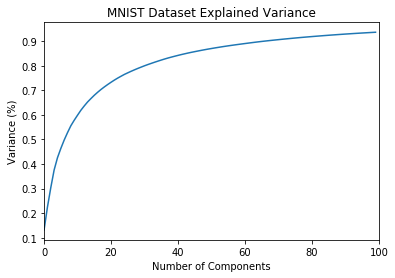

In [158]:
plt.figure()
#Plotting the Cumulative Summation of the Explained Variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,100)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('MNIST Dataset Explained Variance')
plt.show()